#Including Libraries

In [4]:
!pip install pyea
!pip install joblib
!pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Function Declaration

In [14]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import numpy as np
import pandas as pd
from pyea import GeneticAlgorithmOptimizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.utils import column_or_1d

# Define the cost function
def Dimension_alignment(A):
   A = np.reshape(A, (A.shape[0], 1))
   return A

def Sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def Dot_prod(A,B):
  return np.dot(A,B)

def cost_func(theta, X, Y, FN, alpha):
    TP, FP, TN = 4, 4, 0
    weight=np.zeros(theta.shape[0])
    for i in range(theta.shape[0]):
        w_i=theta[i]
        Z = Dot_prod(X, w_i)
        # Clip the values of Z to a range of [-500, 500]
        Z_clipped = np.clip(Z, -500, 500)
        Y_pred = Sigmoid(Z_clipped)
        mat_cost = cost_sens_loss(Y, Y_pred, FN)
        weight[i] = mat_cost
    return weight

def savings(clr,ccs):
  ans = (clr-ccs)/clr
  return ans

def predict(theta, X):
    Mat_Mul=Dot_prod(X,theta)
    pred =Sigmoid(Mat_Mul)
    pred = (pred >= 0.5).astype(int)
    return pred

def cost_sens_loss(Y, Y_pred, FN):
   
    Y =Dimension_alignment(Y)
    Y_pred = Dimension_alignment(Y_pred)
    FN = Dimension_alignment(FN)
    cost=loss_calc(Y,Y_pred,FN)
    return cost 

def loss_calc(Y,Y_pred,FN):
  TP, FP, TN = 4, 4, 0
  part1 = Y*(Y_pred * TP + (1 - Y_pred) * FN)
  part2 = (1 - Y) * (Y_pred * FP + (1 - Y_pred) * TN)
  mat_cost= part1 + part2
  cost = np.sum(mat_cost) / X.shape[0]
  return cost



#Logistic Regression

In [15]:
# Load data
data = pd.read_csv('costsensitiveregression.csv')

# Separate input and output variables
X = data.iloc[:, :-2].values
Y = data.iloc[:, -2].values
False_negative = data.iloc[:, -1].values

# Split data into train and test sets
np.random.seed(33)
X_train, X_test, Y_train, Y_test, FN_train, FN_test = train_test_split(X, Y, False_negative, test_size=0.2, random_state=42)

# Train logistic regression model
logisticRegression = LogisticRegression(max_iter=1000)
logisticRegression.fit(X_train, Y_train)
Y_pred_lr = logisticRegression.predict(X_test)
loss_lr = log_loss(Y_test, Y_pred_lr)
print("Logistic Loss: ", loss_lr)



Logistic Loss:  4.825269637197918


#Cost Sensitive Logistic Regression using pyea library

In [16]:
# Use Genetic Algorithm to train Cost Sensitive Logistic Regression model
theta = np.zeros(X_train.shape[1])
# Set up genetic algorithm optimizer
optimizer = GeneticAlgorithmOptimizer(cost_func,
                                      theta.shape[0],
                                      iters=100,
                                      type_='cont',
                                      n_chromosomes=100,
                                      per_mutations=0.25,
                                      n_elite=10,
                                      fargs=(X_train, Y_train, FN_train, 1.0),
                                      range_=(-5, 5),
                                      n_jobs=1,
                                      verbose=0)

# Run the optimizer
optimizer.fit()
theta = optimizer.x

# Predict using Cost Sensitive Logistic Regression model
Y_pred_Cslr = predict(theta, X_test)
loss_cs = cost_sens_loss(Y_test, Y_pred_Cslr, FN_test)
print("Cost Sensitive Logistic Loss(from pyea lib): ", loss_cs)

# Calculate savings
save_cslr=savings(loss_lr, loss_cs)
print("Cost senstive savings ",save_cslr)

Cost Sensitive Logistic Loss(from pyea lib):  0.5090155163307053
Cost senstive savings  0.8945104513110079


# Alternative Approach using geneticalgorithm library

 The best solution found:
 [6.61976846e-01 6.06303531e-05 9.93361464e-01 9.18855518e-01
 6.31168167e-01 8.46054819e-01 2.55951535e-01 8.89184965e-01
 4.86178343e-05 9.83780006e-01 9.42057656e-01]

 Objective function:
 3.7713623789398696


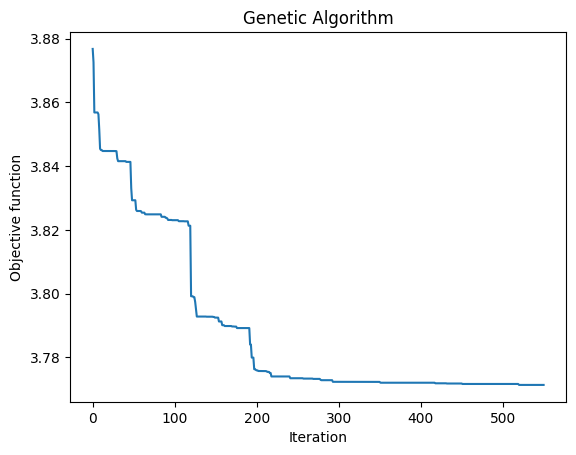

In [19]:
from geneticalgorithm import geneticalgorithm as ga

# Define the cost function
def cost_func(theta):
    y_pred = 1 / (1 + np.exp(-(X @ theta)))
    cost = np.mean(y_true * (y_pred * 4 + (1 - y_pred) * FN) + (1 - y_true) * (y_pred * 4 + (1 - y_pred) * 0))
    return cost
def predict(theta,X):
    y_pred = 1 / (1 + np.exp(-(X @ theta)))
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    return y_pred

# Load data
data = pd.read_csv('costsensitiveregression.csv')

# Separate input and output variables
X = data.iloc[:, :-2].values
y_true = data.iloc[:, -2].values
FN = data.iloc[:, -1].values

# Define bounds for the parameters
bounds = np.zeros((X.shape[1], 2))
bounds[:, 1] = 1

# Run genetic algorithm to minimize the cost function
model = ga(function=cost_func, dimension=X.shape[1], variable_type='real', variable_boundaries=bounds)
model.run()
theta=model.best_variable
y_pred=predict(theta,X_test)


In [18]:
# Print the results
print("Cost Sensitive Logistic Loss(from geneticalgorithm): ", model.best_function)
save=savings(loss_lr,model.best_function)
print("Saving score ",save)

Cost Sensitive Logistic Loss(from geneticalgorithm):  3.7773165963682795
Saving score  0.2171802033094663
